In [2]:
import xarray as xr
import numpy as np
import copernicusmarine
import xesmf as xe
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from ndbc_api import NdbcApi
from datetime import datetime, timedelta
import requests, tarfile, tqdm
import earthaccess
import pandas as pd

auth = earthaccess.login(strategy="interactive", persist=True)

def download_tar(url):
    with open('file.tar.gz', 'wb') as f: f.write(requests.get(url).content)
    with tarfile.open('file.tar.gz') as t: t.extractall()
    return [m.name for m in tarfile.open('file.tar.gz').getmembers()]

crop_global_RTOFS_US = lambda ds: ds.sel(X = slice(1000, 3500), Y = slice(1600, 2250))

In [3]:
# Set up dates and get station data
today = datetime.today()
dates = {
    'today': today.strftime('%Y-%m-%d'),
    'yesterday': (today - timedelta(days=1)).strftime('%Y-%m-%d'),
    'tomorrow': (today + timedelta(days=3)).strftime('%Y-%m-%d')
}

time_range = pd.date_range(
    start=dates['yesterday'],
    end=dates['tomorrow'],
    freq='D'
)

yday = "".join(dates["yesterday"].split("-"))
tday = "".join(dates["today"].split("-"))

RTOFS_sst_url = lambda x: f"https://nomads.ncep.noaa.gov/pub/data/nccf/com/rtofs/prod/rtofs.{x}/rtofs_glo_sst_{x}.tar.gz"

In [4]:
[print(k, ": ", dates[k]) for k in dates.keys()]

today :  2025-02-08
yesterday :  2025-02-07
tomorrow :  2025-02-11


[None, None, None]

In [5]:
# Get station info
api = NdbcApi()
# station_id = '44090' #Nantucket
# station_id = '46221' #LA
station_id = '46222'
station_meta = api.station(station_id=station_id)
location = station_meta["Location"].split()
latitude = float(location[0]) * (-1 if location[1] in ['S'] else 1)
longitude = float(location[2]) * (-1 if location[3] in ['W'] else 1)

In [6]:
# Get CMEMS forecast
forecast_fname = "CMEMS_Theta_Forecast.nc"
if os.path.exists(forecast_fname): os.remove(forecast_fname)
    
copernicusmarine.subset(
    dataset_id="cmems_mod_glo_phy_anfc_0.083deg_PT1H-m",
    variables=["thetao"],
    minimum_longitude=longitude-2, maximum_longitude=longitude+2,
    minimum_latitude=latitude-2, maximum_latitude=latitude+2,
    start_datetime=dates['yesterday'], end_datetime=dates['tomorrow'],
    minimum_depth=0, maximum_depth=1,
    output_filename=forecast_fname,
    username="ameza", password="Ameza1998", 
    force_download=True
)

# Process forecast data
CMEMS_Forecast = (xr.open_dataset(forecast_fname)
                   .isel(depth=0)
                   .drop_vars("depth")
                   .thetao
                   .rename({"latitude": "lat", "longitude": "lon"}))
# Interpolate forecast to buoy location
ds_locs = xr.Dataset({
    "lon": xr.DataArray([longitude], dims="locations"),
    "lat": xr.DataArray([latitude], dims="locations")
})

regridder = xe.Regridder(CMEMS_Forecast, ds_locs, "bilinear", locstream_out=True)
CMEMS_Forecast_at_loc = regridder(CMEMS_Forecast).isel(locations=0)

WARNING - 2025-02-08T05:31:45Z - 'force_download' has been deprecated.
INFO - 2025-02-08T05:31:47Z - Selected dataset version: "202406"
INFO - 2025-02-08T05:31:47Z - Selected dataset part: "default"
WARNING - 2025-02-08T05:31:52Z - Some of your subset selection [0, 1] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 0.49402499198913574]
INFO - 2025-02-08T05:31:55Z - Starting download. Please wait...


  0%|          | 0/18 [00:00<?, ?it/s]

INFO - 2025-02-08T05:31:58Z - Successfully downloaded to CMEMS_Theta_Forecast.nc


In [7]:
results = earthaccess.search_data(short_name="OSTIA-UKMO-L4-GLOB-v2.0",
                                  cloud_hosted=True,
                                  temporal = (dates['yesterday'],dates['tomorrow']),
                                  bounding_box=(longitude-2,latitude-2, longitude+2,latitude+2))
files = earthaccess.download(results, "./")
downloaded_files = []
for f in files: 
    downloaded_files.append(f)
    
def preprocess(ds):
    dstmp = ds.sel(lon = slice(longitude-2,longitude+2), lat=slice(latitude-2,latitude+2))
    dstmp = dstmp["analysed_sst"] - 273.15
    return dstmp
GHRSST_ds = xr.open_mfdataset(downloaded_files, preprocess = preprocess).compute()
# GHRSST_ds = GHRSST_ds.sel(time = slice(dates['yesterday'],None))
GHRSST_ds = GHRSST_ds["analysed_sst"].resample(time="1D").mean("time")

regridder = xe.Regridder(GHRSST_ds, ds_locs, "bilinear", locstream_out=True)
GHRSST_locs = regridder(GHRSST_ds).isel(locations = 0)
GHRSST_locs = GHRSST_locs.reindex(time=time_range, fill_value=np.nan)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# %%time
for day in [yday, tday]:
    try:
      untarred_files = download_tar(RTOFS_sst_url(day))
    except:
      print("Yesterday forecast unavailable")
        
RTOFS_sst = xr.open_mfdataset(untarred_files, combine='nested', concat_dim = "MT")
RTOFS_sst = crop_global_RTOFS_US(RTOFS_sst)["sst"].compute()
RTOFS_sst = RTOFS_sst.rename({"Longitude":"lon", "Latitude":"lat", "MT":"time"})
RTOFS_sst = RTOFS_sst.drop_duplicates("time")

regridder = xe.Regridder(RTOFS_sst, ds_locs, "bilinear", locstream_out=True)

RTOFS_sst_loc = regridder(RTOFS_sst)
RTOFS_sst_loc = RTOFS_sst_loc.interp(time=CMEMS_Forecast.time)

Yesterday forecast unavailable


In [9]:
# Get and process buoy data
stdmet_df = (api.get_data(station_ids=[station_id], mode='stdmet',
                         start_time=dates['yesterday'],
                         end_time=dates['tomorrow'])
             .rename_axis(index='time')
             .pipe(xr.Dataset.from_dataframe)
             .interp(time=CMEMS_Forecast.time))
stdmet_df_final = stdmet_df.isel(time=~stdmet_df["WTMP"].isnull().values).isel(time=-1)

Text(0.5, 0, 'Time')

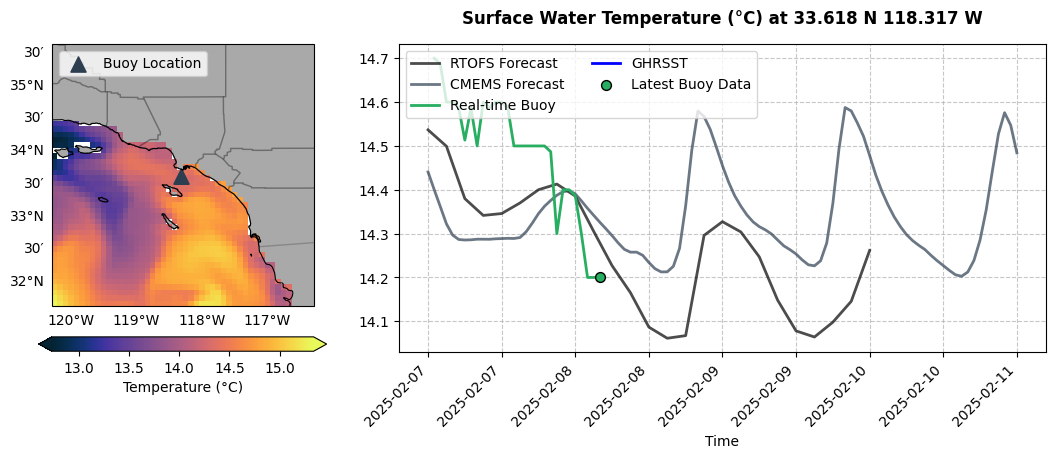

In [10]:
# Create plot
fig = plt.figure(figsize=(13, 4), facecolor='white')
gs = gridspec.GridSpec(1, 3, figure=fig, wspace=0.25)

# Map subplot
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, facecolor='darkgrey')
ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_2_counties', '10m',
                                            facecolor='none', edgecolor='k'),
                linewidth=1, alpha=0.2)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Add gridlines and map features
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                   linewidth=0.5, color='gray', alpha=0.01, linestyle='--')
gl.top_labels = gl.right_labels = False

# Add temperature contour
contour = ax1.pcolormesh(CMEMS_Forecast.lon, CMEMS_Forecast.lat, 
                        CMEMS_Forecast.mean("time"),
                        transform=ccrs.PlateCarree(),
                        cmap=cmocean.cm.thermal)
fig.colorbar(contour, ax=ax1, orientation='horizontal', 
            pad=0.1, fraction=0.05, label='Temperature (°C)',
            extend="both")

# Add buoy marker
ax1.scatter(longitude, latitude, c='#2c3e50', s=120, marker='^', 
           transform=ccrs.PlateCarree(), label='Buoy Location')
ax1.legend(loc='upper left')

# Time series subplot
ax2 = fig.add_subplot(gs[0, 1:])
ax2.set_title(f"Surface Water Temperature (°C) at {' '.join(location[0:4])}", 
              pad=15, fontweight="bold")
ax2.grid(True, linestyle='--', alpha=0.7)

# Add time series
ax2.plot(RTOFS_sst_loc.time.values, RTOFS_sst_loc.values, 
         color='k', alpha=0.7, linewidth=2, label='RTOFS Forecast')

ax2.plot(CMEMS_Forecast_at_loc.time.values, CMEMS_Forecast_at_loc.values, 
         color='#2c3e50', alpha=0.7, linewidth=2, label='CMEMS Forecast')

ax2.plot(stdmet_df.time.values, stdmet_df["WTMP"].values, 
         color='#27ae60', linewidth=2, label='Real-time Buoy')

ax2.step(GHRSST_locs.time.values, GHRSST_locs.values, where='post',
        color='b', linewidth=2, label='GHRSST')


ax2.scatter(stdmet_df_final.time, stdmet_df_final["WTMP"].values, 
            color='#27ae60', label='Latest Buoy Data', 
            s=50, edgecolor='black', zorder=5)

# Format time series
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax2.legend(loc='upper left', ncols = 2)
ax2.set_xlabel('Time')